In [1]:
import os
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2025-03-06 14:37:08.018008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741300628.035444 2137143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741300628.040675 2137143 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

In [2]:
from sampler_evaluation.models import models
from sampler_evaluation.models.standardgaussian import Gaussian
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error


model=banana()

samples, metadata = samplers['nuts'](return_samples=True)(
        model=gym.targets.Banana(), 
        num_steps=10000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(2,)), 
        key=jax.random.key(0))


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

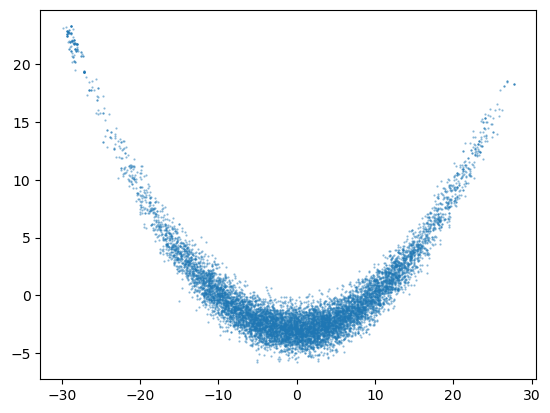

In [3]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

## Running multiple chains

Often we want to run multiple chains in parallel. In Jax, this can be done as follows:

In [4]:
batch_size = 128

init_keys = jax.random.split(jax.random.key(3), batch_size)

keys = jax.random.split(jax.random.key(3), batch_size)

initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)

num_steps = 20000

samples, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=True)(
        model=model, num_steps=num_steps, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

## Analysing the efficiency of the sampler

To analyse the efficiency of the sampler, we can calculate the *standardized squared error* of $x^2$ and $x$,  respectively defined as:

$\frac{(E_{\mathit{sampler}}[x^2]-E[x^2])^2}{Var[x^2]}$ and $\frac{(E_{\mathit{sampler}}[x]-E[x])^2}{Var[x]}$, where $E_{\mathit{sampler}}$ is the empirical estimate of the expectation. We can then count how many steps of the kernel (and in particular for gradient based samplers, how many gradient calls), it takes for these statistics to drop below a threshold (by default $0.01$). In code:

In [5]:
samples.shape

(128, 20000, 2)

In [6]:

error_at_each_step = get_standardized_squared_error(
    samples, 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2
    )

gradient_calls_per_chain = metadata['num_grads_per_proposal'].mean()

samples_to_low_error(error_at_each_step) * gradient_calls_per_chain

Error below threshold at final error 0.006967142689973116


Array(107792.96, dtype=float32)

## Streaming averages, for large models

For models with many parameters (that is, high dimensional distributions), the array of samples, of shape `[batch_size, num_samples, num_dimensions]`, can be too large to fit in memory. However, all we need to keep at each step is a streaming average of the expectations $\mathbb{E}[x]$ and $\mathbb{E}[x^2]$, and return an array of the standarized squared errors at each step, of shape `[num_samples]`.

This is done as follows:

In [7]:
squared_errors, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=False)(
        model=model, num_steps=20000, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

err_t_max_x2 = jnp.median(squared_errors[:, :, 1], axis=0)
samples_to_low_max_x2 = samples_to_low_error(
err_t_max_x2)* metadata["num_grads_per_proposal"].mean()


samples_to_low_max_x2

Error below threshold at final error 0.006967106368392706


Array(107792.96, dtype=float32)

## Inspecting benchmark results

This repository provides precalculated results of measuring the efficiency of a range of samplers on a range of models. These results can be viewed as follows:

In [1]:
import itertools
import os
import pandas as pd
from sampler_comparison.samplers import samplers
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.german_credit import german_credit
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from sampler_evaluation.models.item_response import item_response
from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
from sampler_evaluation.models.neals_funnel import neals_funnel
from sampler_evaluation.models.banana_mams_paper import banana_mams_paper

models = {
    "Banana_MAMS_Paper": banana_mams_paper,
    "Banana": banana(),
    "Gaussian_MAMS_Paper": IllConditionedGaussian(ndims=100, condition_number=100, eigenvalues='log'),
    "Brownian_Motion": brownian_motion(),
    "German_Credit": german_credit(),
    "Rosenbrock": Rosenbrock_36D(),
    # "Neals_Funnel_MAMS_Paper": neals_funnel(),
    "Stochastic_Volatility_MAMS_Paper": stochastic_volatility_mams_paper,
    "Item_Response": item_response(),
}

df = pd.concat([pd.read_csv(os.path.join('../..',f'results/{model}', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2025-03-07 05:55:48.235239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741355748.399758  223097 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741355748.444807  223097 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 sh

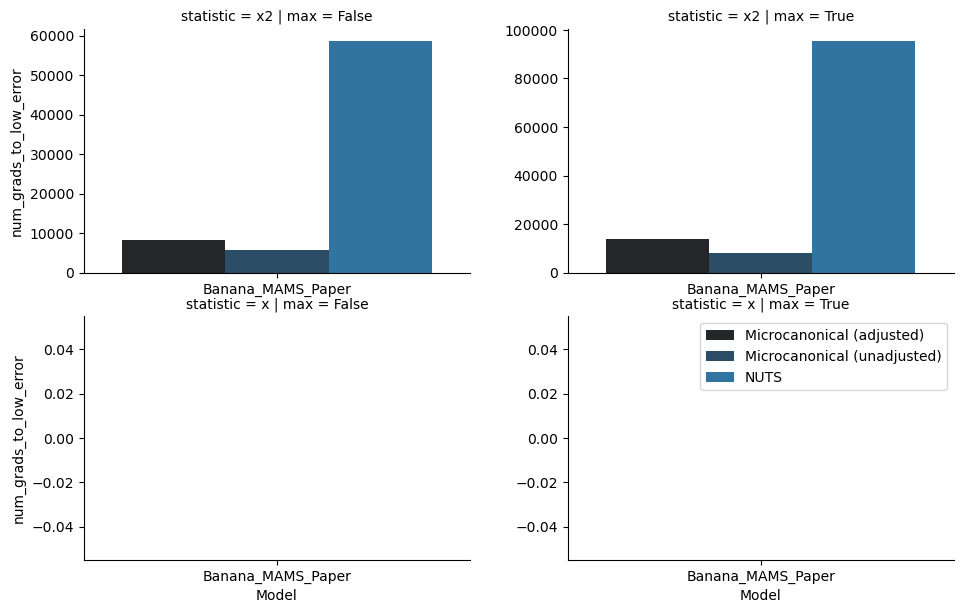

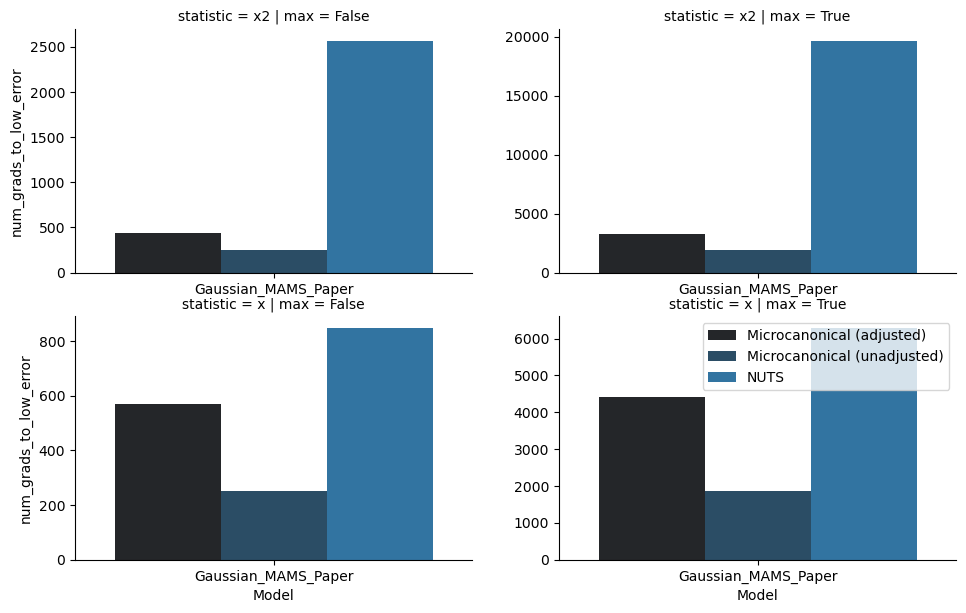

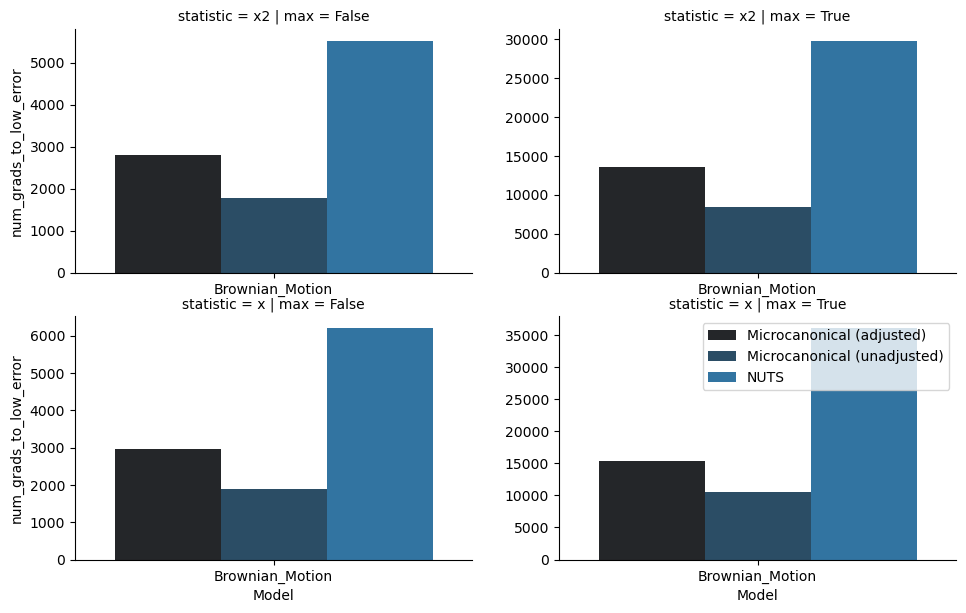

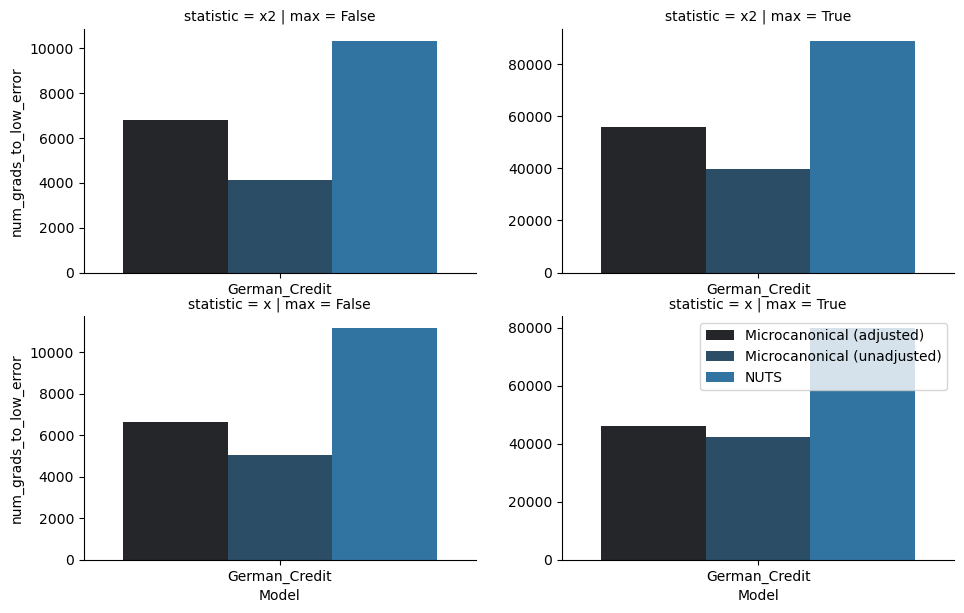

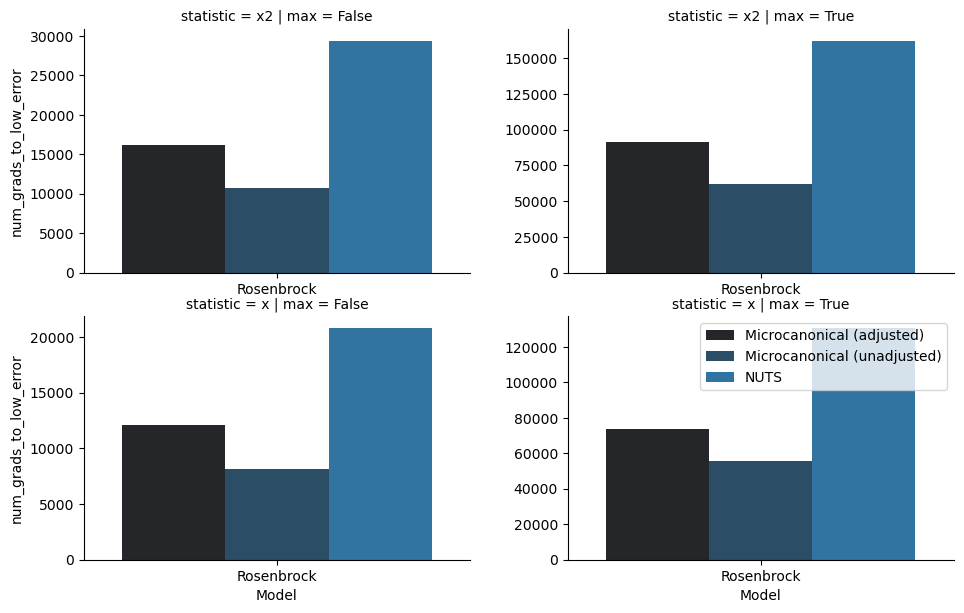

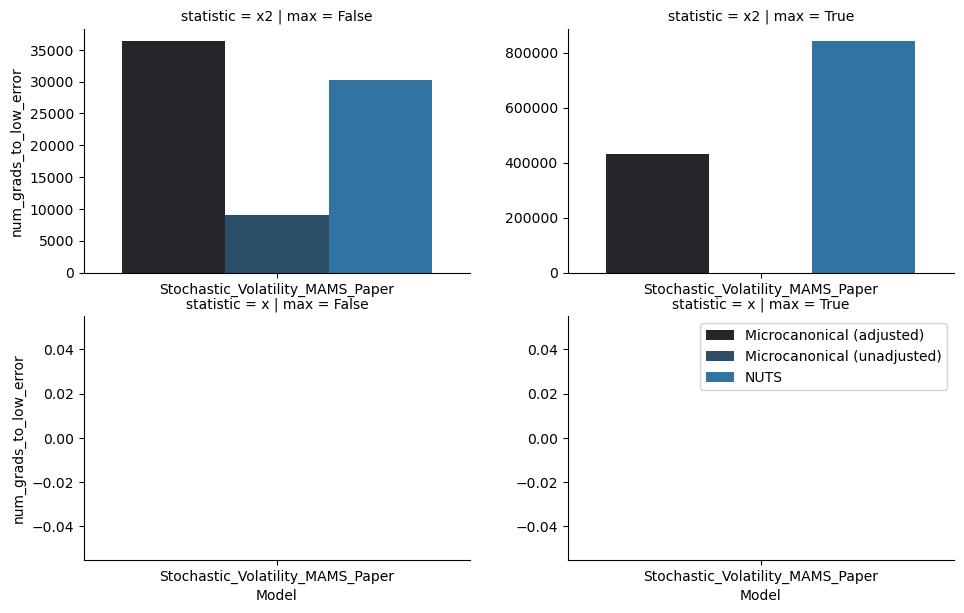

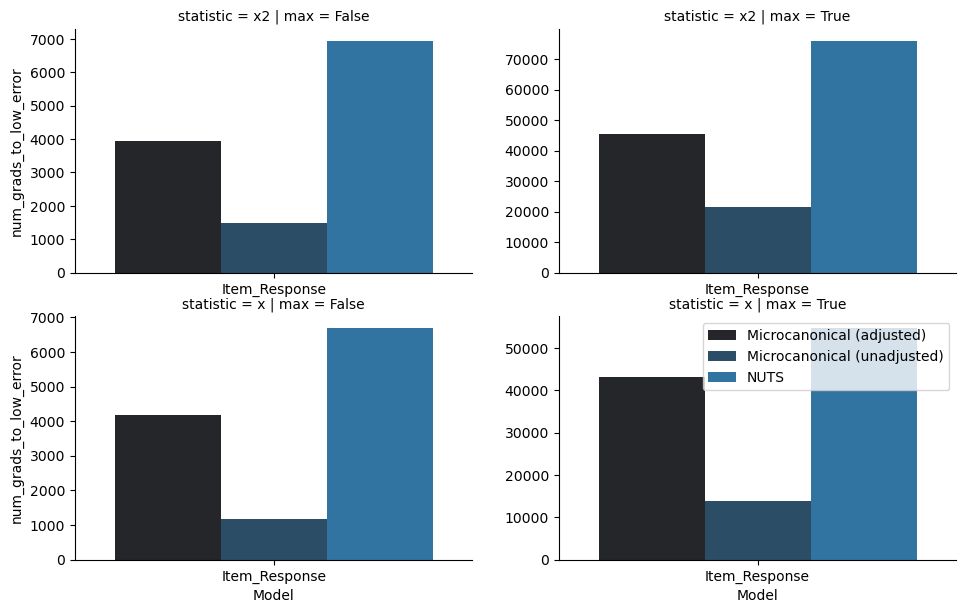

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({"nuts": "NUTS", "unadjusted_microcanonical": "Microcanonical (unadjusted)", "adjusted_microcanonical": "Microcanonical (adjusted)"}.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'Model',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["Model"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  plt.gcf().set_size_inches(10, 6)
  plt.show()

for model in models:
  display_results(model, df, include_tuning=False)

In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,max,statistic,num_tuning_grads,L,step_size
0,0,adjusted_microcanonical,Banana_MAMS_Paper,1.407867e+04,True,x2,1.529316e+05,2.828427,0.177159
1,1,adjusted_microcanonical,Banana_MAMS_Paper,8.247459e+03,False,x2,1.529316e+05,2.828427,0.177159
2,2,adjusted_microcanonical,Banana_MAMS_Paper,inf,True,x,1.529316e+05,2.828427,0.177159
3,3,adjusted_microcanonical,Banana_MAMS_Paper,inf,False,x,1.529316e+05,2.828427,0.177159
4,0,adjusted_microcanonical,Gaussian_MAMS_Paper,3.249524e+03,True,x2,7.299984e+04,10.291699,5.596306
5,1,adjusted_microcanonical,Gaussian_MAMS_Paper,4.342512e+02,False,x2,7.299984e+04,10.291699,5.596306
6,2,adjusted_microcanonical,Gaussian_MAMS_Paper,4.414274e+03,True,x,7.299984e+04,10.291699,5.596306
7,3,adjusted_microcanonical,Gaussian_MAMS_Paper,5.704147e+02,False,x,7.299984e+04,10.291699,5.596306
8,0,adjusted_microcanonical,Brownian_Motion,1.352831e+04,True,x2,1.862522e+05,11.313708,1.086937
9,1,adjusted_microcanonical,Brownian_Motion,2.797522e+03,False,x2,1.862522e+05,11.313708,1.086937
